# Pump it Up: Data Mining the Water Table

# By Yang Xi (A01825725W) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Data Cleaning and Exploration

In [2]:
df = pd.read_csv('Training_set_values.csv')
df.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... payment_type  \
0  34.938093  -9.856322                  none            0  ...     annually   
1  34.698766  -2.147466              Zahanati            0  ...    never pay   
2  37.460664  -3.821329           Kwa Mahundi            0  ...   per bucket   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...    never pay   
4  31.130847  -1.825359               Shuleni            0  ...    never pay   

  water_quality quality_group      quantity  quantity_group  \
0          soft          good        enough          enough   
1          soft          good  insufficient    insufficient   
2          soft          good        enough          enough   
3          soft          good           dry             dry   
4          soft          good      seasonal        seasonal   

                 source           source_type  source_class  \
0                spring                spring   groundwater   
1  rainwater harvesting  rainwater harvesting       surface   
2                   dam                   dam       surface   
3           machine dbh              borehole   groundwater   
4  rainwater harvesting  rainwater harvesting       surface   

               waterpoint_type waterpoint_type_group  
0           communal standpipe    communal standpipe  
1           communal standpipe    communal standpipe  
2  communal standpipe multiple    communal standpipe  
3  communal standpipe multiple    communal standpipe  
4           communal standpipe    communal standpipe  

[5 rows x 40 columns]

To lower case of all data in column 'funder' and 'installer'

In [3]:
df[['funder','installer']]=df[['funder','installer']].applymap(lambda x:x.lower() if isinstance(x, str) else x)

From the table above, we observe that there are 40 features. Most of the features are categorical and some are numerical features. We observe that there are Nan values in column 'funder' and 'installer', so we check whether other features contain Nan values. 
Fisrtly, we check if Nan values exists in numerical features. 

In [4]:
df_num = df.select_dtypes(include='number', exclude=object)
df_num[df_num.isna().any(axis=1)]

Empty DataFrame
Columns: [id, amount_tsh, gps_height, longitude, latitude, num_private, region_code, district_code, population, construction_year]
Index: []

We found that none of the numerical features has NaN value. 

From the dataframe, we observe that some data value of "None/none" instead of "NaN", so we need to standardise all the NaN and "0" value format. By do this: 

In [5]:
df_obj = df.select_dtypes(exclude='number')
df_obj.replace(value=['nodata/none','nodata/none','nodata/none','nodata/none','zero','zero','zero'], 
                                            to_replace=['NaN','None','none',np.NaN,'0',0,0.0], inplace=True)
df_cleaned = pd.concat(objs=[df_obj, df_num], axis=1)

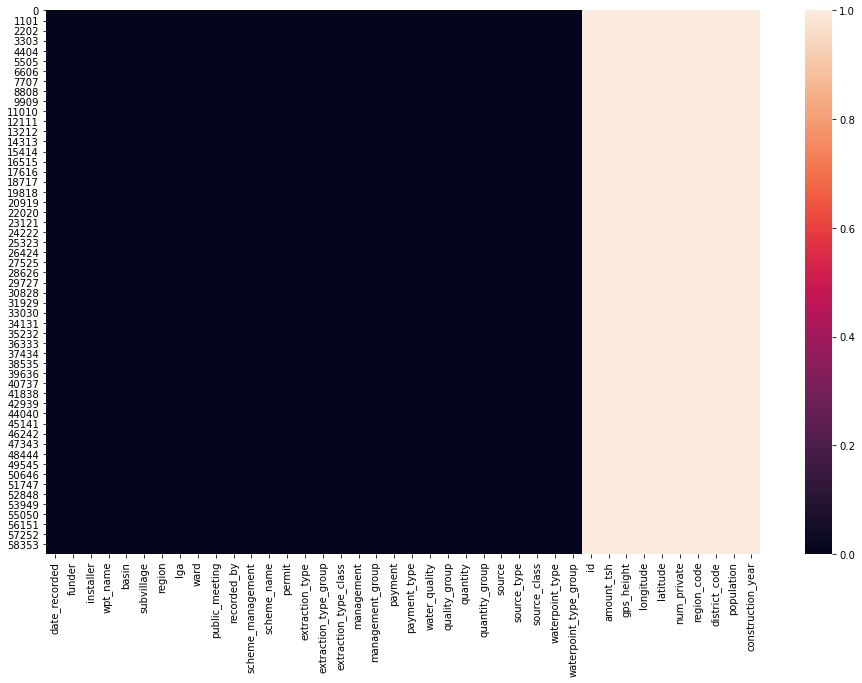

In [6]:
plt.figure(figsize=[16,10])
df_check = df_cleaned.applymap(lambda x:1 if ((isinstance(x, int) or isinstance(x, float)) 
                                              and not isinstance(x, bool)) else 0)
sns.heatmap(df_check)

After some preprocessing, we clear all NaN values in the dataframe, and the categorical columns only have object dtype and the numerical columns only have numeric dtype. 


In [7]:
print('Total number of entries = {}'.format(df_cleaned.count()[0]))
print('Total number of distinct waterpoint ids = {}'.format(df_cleaned.id.nunique()))

Total number of entries = 59400
Total number of distinct waterpoint ids = 59400


After checking distinct ids, we found that there is no duplicate pumb data in our dataframe 

Next, we conduct some data exploration. 

In [8]:
print(df_cleaned['construction_year'].unique())

[1999 2010 2009 1986    0 2011 1987 1991 1978 1992 2008 1974 2000 2002
 2004 1972 2003 1980 2007 1973 1985 1970 1995 2006 1962 2005 1997 2012
 1996 1977 1983 1984 1990 1982 1976 1988 1989 1975 1960 1961 1998 1963
 1971 1994 1968 1993 2001 1979 1967 2013 1969 1981 1964 1966 1965]


We found that there exist a '0' construction year in the dataframe, which is an error. Over here, we assume that '0' is the earliest year in the dataframe, so we replace '0' with '1950' because we observe that '1950' is earlier than all the years in the dataframe.  

In [9]:
df_cleaned['construction_year'].replace(to_replace=0, value=1950, inplace=True)
df_cleaned['construction_year'].unique()

array([1999, 2010, 2009, 1986, 1950, 2011, 1987, 1991, 1978, 1992, 2008,
       1974, 2000, 2002, 2004, 1972, 2003, 1980, 2007, 1973, 1985, 1970,
       1995, 2006, 1962, 2005, 1997, 2012, 1996, 1977, 1983, 1984, 1990,
       1982, 1976, 1988, 1989, 1975, 1960, 1961, 1998, 1963, 1971, 1994,
       1968, 1993, 2001, 1979, 1967, 2013, 1969, 1981, 1964, 1966, 1965],
      dtype=int64)

Read in the Training Set to have a look.

In [10]:
df_label = pd.read_csv('Training_set_labels.csv')
df_label.head()

id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional

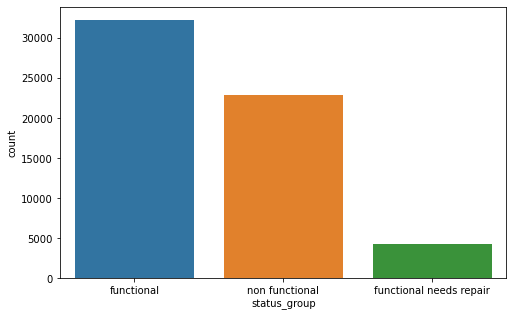

In [11]:
plt.figure(figsize=[8,5])
sns.countplot(data=df_label, x='status_group')

In [12]:
df_join = pd.merge(left=df_cleaned, right=df_label, how='inner', on='id')
df_join.head()

date_recorded        funder     installer              wpt_name  \
0    2011-03-14         roman         roman           nodata/none   
1    2013-03-06       grumeti       grumeti              Zahanati   
2    2013-02-25  lottery club  world vision           Kwa Mahundi   
3    2013-01-28        unicef        unicef  Zahanati Ya Nanyumbu   
4    2011-07-13   action in a       artisan               Shuleni   

                     basin  subvillage   region        lga        ward  \
0               Lake Nyasa    Mnyusi B   Iringa     Ludewa    Mundindi   
1            Lake Victoria     Nyamara     Mara  Serengeti       Natta   
2                  Pangani     Majengo  Manyara  Simanjiro     Ngorika   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara   Nanyumbu    Nanyumbu   
4            Lake Victoria  Kyanyamisa   Kagera    Karagwe  Nyakasimbi   

  public_meeting  ... amount_tsh gps_height  longitude   latitude num_private  \
0           True  ...     6000.0       1390  34.938093  -9.856322           0   
1    nodata/none  ...        0.0       1399  34.698766  -2.147466           0   
2           True  ...       25.0        686  37.460664  -3.821329           0   
3           True  ...        0.0        263  38.486161 -11.155298           0   
4           True  ...        0.0          0  31.130847  -1.825359           0   

  region_code district_code population construction_year    status_group  
0          11             5        109              1999      functional  
1          20             2        280              2010      functional  
2          21             4        250              2009      functional  
3          90            63         58              1986  non functional  
4          18             1          0              1950      functional  

[5 rows x 41 columns]

In [13]:
df_join.columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'id',
       'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'construction_year',
       'status_group'],
      dtype='object')

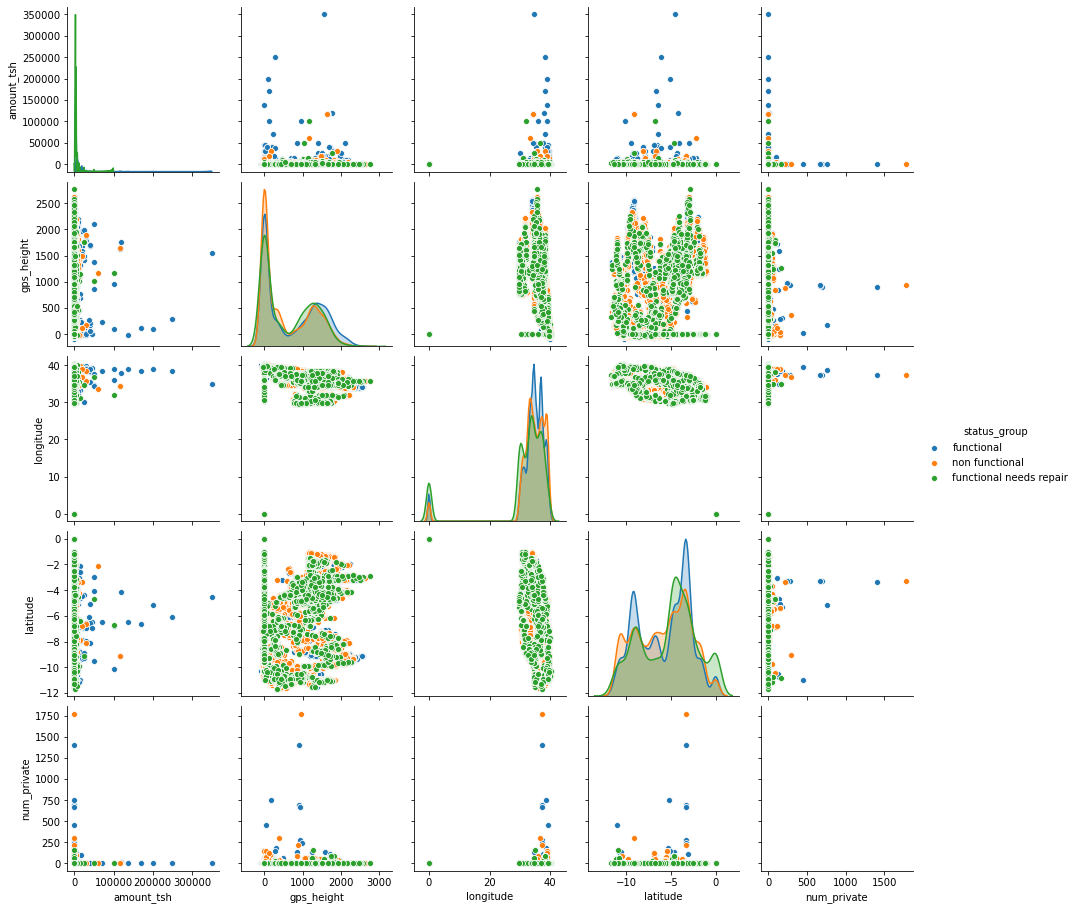

In [14]:
sns.pairplot(data=df_join.drop(labels=['id'], axis=1), hue='status_group', 
             x_vars=df.select_dtypes(exclude=object).columns[1:6], 
             y_vars=df.select_dtypes(exclude=object).columns[1:6])

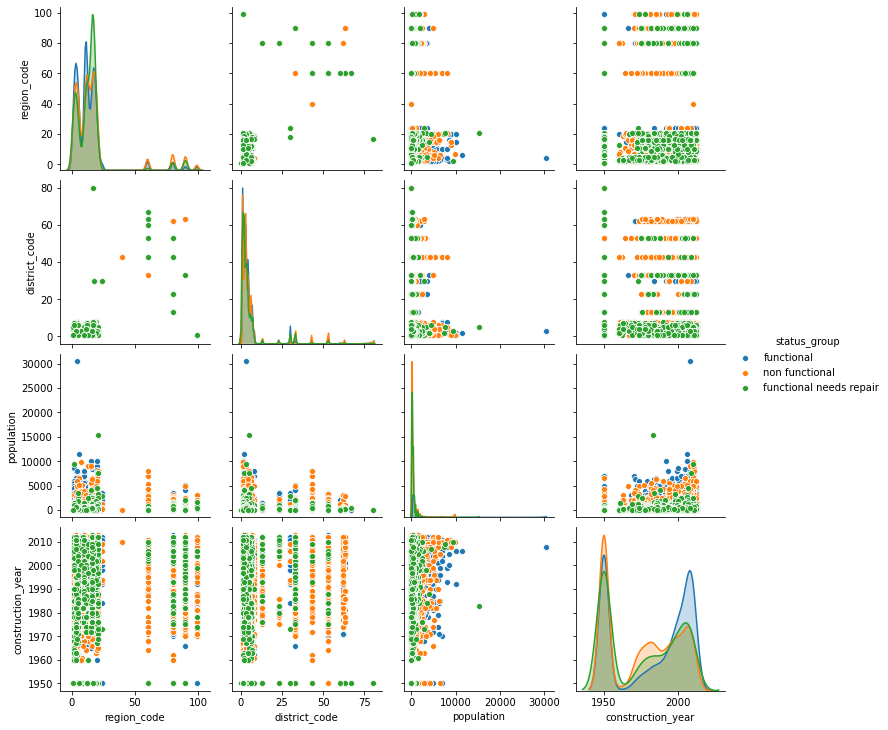

In [15]:
sns.pairplot(data=df_join.drop(labels=['id'], axis=1), hue='status_group', 
             x_vars=df.select_dtypes(exclude=object).columns[6:12], 
             y_vars=df.select_dtypes(exclude=object).columns[6:12])

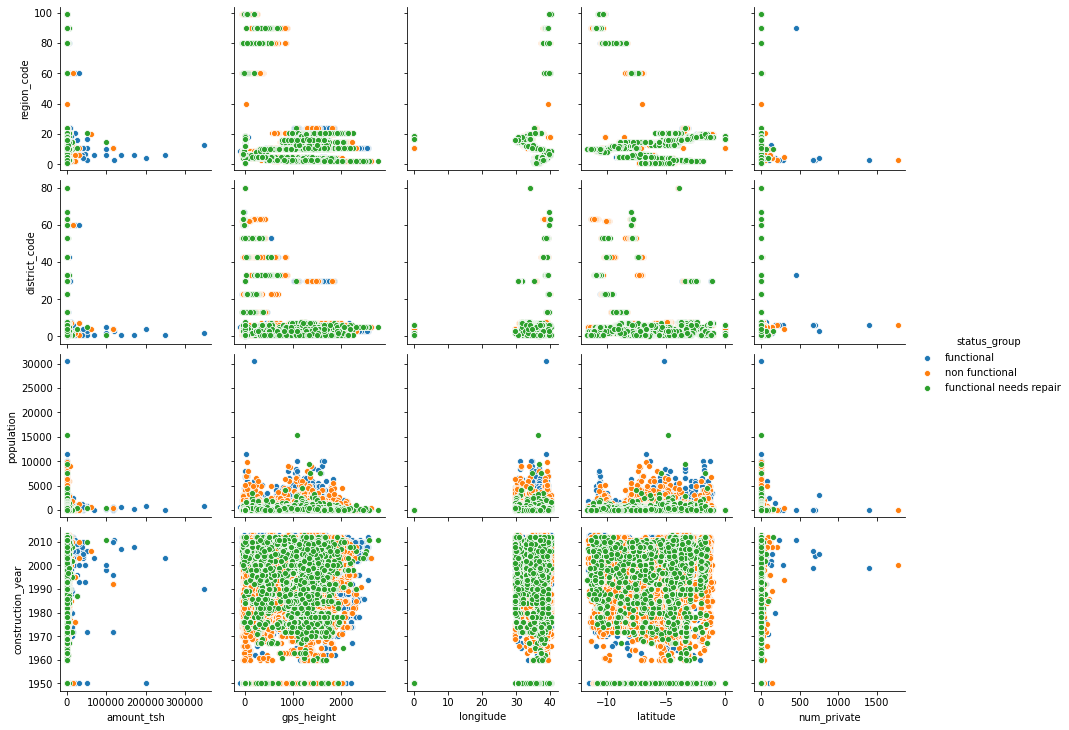

In [16]:
sns.pairplot(data=df_join.drop(labels=['id'], axis=1), hue='status_group', 
             x_vars=df.select_dtypes(exclude=object).columns[1:6], 
             y_vars=df.select_dtypes(exclude=object).columns[6:12])

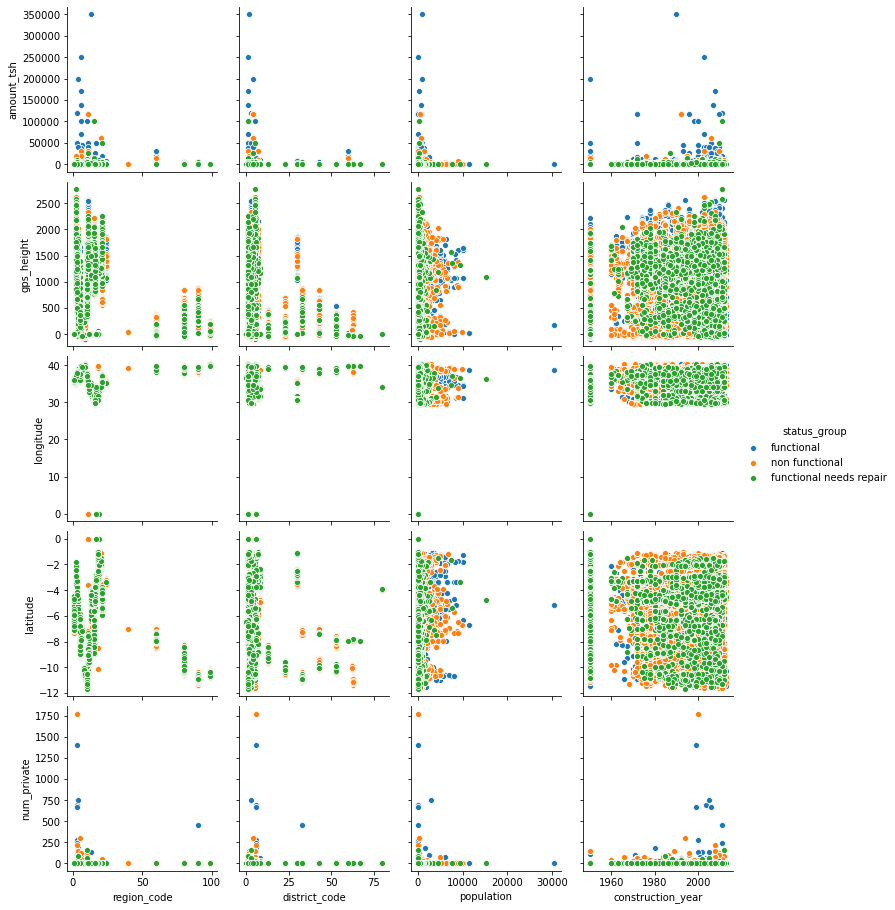

In [17]:
sns.pairplot(data=df_join.drop(labels=['id'], axis=1), hue='status_group', 
             x_vars=df.select_dtypes(exclude=object).columns[6:12], 
             y_vars=df.select_dtypes(exclude=object).columns[1:6])

As we observe from the pairplot above, we found that these are the variables that are more likely to separate the targets are:
1. population
2. gps_height
3. amount_tsh
4. num_private
5. year constructed

## Preprocessing and Feature Engineering

At first, a new feature 'amount_tsh_percapita' is created to help in seperating the classes.

In [19]:
df_join['amount_tsh_percapita'] = list(map(lambda x,y: x/(y+1), df_join['amount_tsh'], df_join['population']))
#The +1 is to prevent divison by 0

In [21]:
df_cat_features=df_join.select_dtypes(exclude='number')
Ser1=df_cat_features.nunique()
Ser1.where(Ser1<=25).dropna()

basin                     9.0
region                   21.0
public_meeting            3.0
recorded_by               1.0
scheme_management        12.0
permit                    3.0
extraction_type          18.0
extraction_type_group    13.0
extraction_type_class     7.0
management               12.0
management_group          5.0
payment                   7.0
payment_type              7.0
water_quality             8.0
quality_group             6.0
quantity                  5.0
quantity_group            5.0
source                   10.0
source_type               7.0
source_class              3.0
waterpoint_type           7.0
waterpoint_type_group     6.0
status_group              3.0
dtype: float64

In [22]:
df_cat_features[Ser1.where(Ser1<=25).dropna().index].head()

basin   region public_meeting              recorded_by  \
0               Lake Nyasa   Iringa           True  GeoData Consultants Ltd   
1            Lake Victoria     Mara    nodata/none  GeoData Consultants Ltd   
2                  Pangani  Manyara           True  GeoData Consultants Ltd   
3  Ruvuma / Southern Coast   Mtwara           True  GeoData Consultants Ltd   
4            Lake Victoria   Kagera           True  GeoData Consultants Ltd   

  scheme_management permit extraction_type extraction_type_group  \
0               VWC   zero         gravity               gravity   
1             Other   True         gravity               gravity   
2               VWC   True         gravity               gravity   
3               VWC   True     submersible           submersible   
4       nodata/none   True         gravity               gravity   

  extraction_type_class management  ... water_quality quality_group  \
0               gravity        vwc  ...          soft          good   
1               gravity        wug  ...          soft          good   
2               gravity        vwc  ...          soft          good   
3           submersible        vwc  ...          soft          good   
4               gravity      other  ...          soft          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type waterpoint_type_group  \
0  groundwater           communal standpipe    communal standpipe   
1      surface           communal standpipe    communal standpipe   
2      surface  communal standpipe multiple    communal standpipe   
3  groundwater  communal standpipe multiple    communal standpipe   
4      surface           communal standpipe    communal standpipe   

     status_group  
0      functional  
1      functional  
2      functional  
3  non functional  
4      functional  

[5 rows x 23 columns]

From the above table, We can observe that some features are similiar. For example: 
1. quantity & quantity_group
2. payment & payment_type
3. water_quality & quality group
4. source, source_type & source class
5. waterpoint_type & waterpoint_type_group
6. scheme_management & management_group
7. extraction_type, extraction_type_group & extraction_type_class

We also observe that 
1. "recorded_by" only has one value - which is most likely not a factor affecting the functionality of the waterpoint.
2. "status_group" is the dependent variable y

[Text(0, 0, 'vwc'),
 Text(0, 0, 'wug'),
 Text(0, 0, 'other'),
 Text(0, 0, 'private operator'),
 Text(0, 0, 'water board'),
 Text(0, 0, 'wua'),
 Text(0, 0, 'company'),
 Text(0, 0, 'water authority'),
 Text(0, 0, 'parastatal'),
 Text(0, 0, 'unknown'),
 Text(0, 0, 'other - school'),
 Text(0, 0, 'trust')]

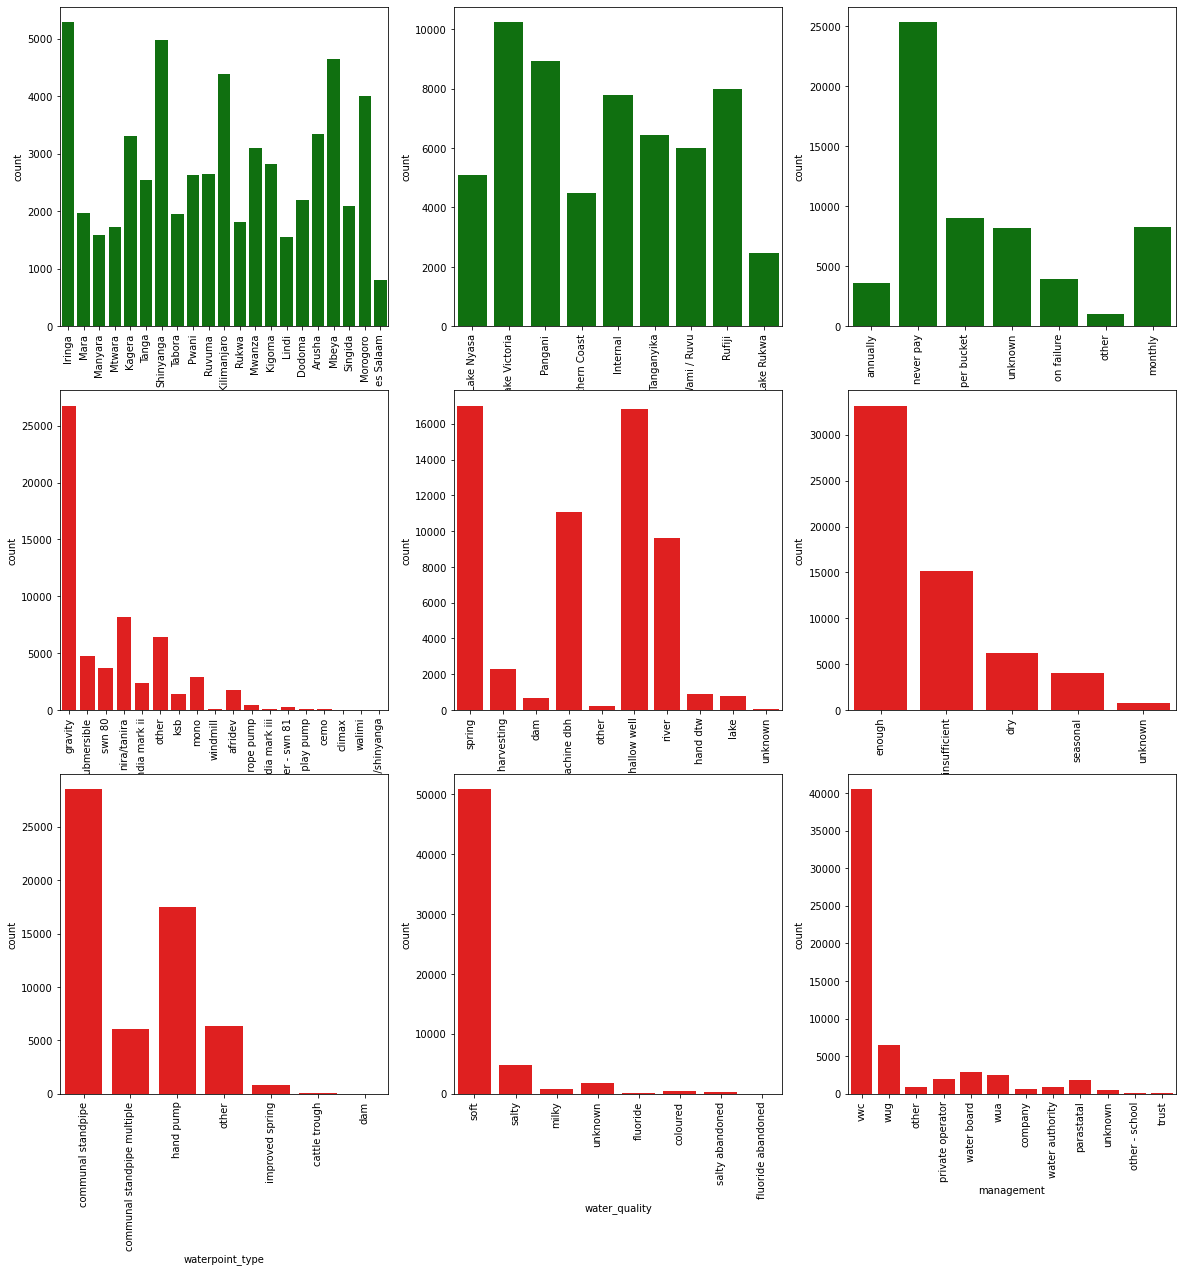

In [23]:
fig, ax = plt.subplots(ncols=3, nrows=3)
fig.set_figheight(20)
fig.set_figwidth(20)
sns.countplot(x='region', data=df_join, ax=ax[0][0], color='green')
sns.countplot(x='basin', data=df_join, ax=ax[0][1], color='green')
sns.countplot(x='payment_type', data=df_join, ax=ax[0][2], color='green')
sns.countplot(x='extraction_type', data=df_join, ax=ax[1][0], color='red')
sns.countplot(x='source', data=df_join, ax=ax[1][1], color='red')
sns.countplot(x='quantity', data=df_join, ax=ax[1][2], color='red')
sns.countplot(x='waterpoint_type', data=df_join, ax=ax[2][0], color='red')
sns.countplot(x='water_quality', data=df_join, ax=ax[2][1], color='red')
sns.countplot(x='management', data=df_join, ax=ax[2][2], color='red')
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=90)
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=90)
ax[0][2].set_xticklabels(ax[0][2].get_xticklabels(), rotation=90)
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=90)
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=90)
ax[1][2].set_xticklabels(ax[1][2].get_xticklabels(), rotation=90)
ax[2][0].set_xticklabels(ax[2][0].get_xticklabels(), rotation=90)
ax[2][1].set_xticklabels(ax[2][1].get_xticklabels(), rotation=90)
ax[2][2].set_xticklabels(ax[2][2].get_xticklabels(), rotation=90)

From the above chart, we observe that, in some categorical features, some types have very little quantity. For example, in waterpoint_type, 'cattle trough' and 'dam' have very low count.
Hence, We group those data with low count name it "Others" 

First 3 features - 'region', 'basin', 'payment type', we observe there is no need to process these 3 features. 
For the ramining 6 features, we group the categories with count < 0.5% total count of the feature. 

In [24]:
df_cleaned.count()[0]*0.005

297.0

In [25]:
df_join['extraction_type_regrouped'] = df_join['extraction_type'].apply(lambda x:x if x not in 
                                 ('windmill','india mark iii',
                                  'other - swn 81','other - play pump','cemo',
                                   'climax', 'walimi', 'other - mkulima/shinyanga') else 'others')
df_join['source_regrouped'] = df_join['source'].apply(lambda x:x if x not in
                                                      ('other','unknown') else 'others')

In [26]:
df_join['waterpoint_type_regrouped'] = df_join['waterpoint_type'].apply(lambda x:x if x not in
                                        ('cattle trough', 'dam') else 'cattle trough/dam')
df_join['water_quality_regrouped'] = df_join['water_quality'].apply(lambda x:x if x not in
                                        ('fluoride','fluoride abandoned') else 'fluoride_group')
df_join['management_regrouped'] = df_join['management'].apply(lambda x:x if x not in
                                        ('other - school', 'trust') else 'school/trust')

df_join.head()

date_recorded        funder     installer              wpt_name  \
0    2011-03-14         roman         roman           nodata/none   
1    2013-03-06       grumeti       grumeti              Zahanati   
2    2013-02-25  lottery club  world vision           Kwa Mahundi   
3    2013-01-28        unicef        unicef  Zahanati Ya Nanyumbu   
4    2011-07-13   action in a       artisan               Shuleni   

                     basin  subvillage   region        lga        ward  \
0               Lake Nyasa    Mnyusi B   Iringa     Ludewa    Mundindi   
1            Lake Victoria     Nyamara     Mara  Serengeti       Natta   
2                  Pangani     Majengo  Manyara  Simanjiro     Ngorika   
3  Ruvuma / Southern Coast  Mahakamani   Mtwara   Nanyumbu    Nanyumbu   
4            Lake Victoria  Kyanyamisa   Kagera    Karagwe  Nyakasimbi   

  public_meeting  ... district_code population construction_year  \
0           True  ...             5        109              1999   
1    nodata/none  ...             2        280              2010   
2           True  ...             4        250              2009   
3           True  ...            63         58              1986   
4           True  ...             1          0              1950   

     status_group amount_tsh_percapita extraction_type_regrouped  \
0      functional            54.545455                   gravity   
1      functional             0.000000                   gravity   
2      functional             0.099602                   gravity   
3  non functional             0.000000               submersible   
4      functional             0.000000                   gravity   

       source_regrouped    waterpoint_type_regrouped water_quality_regrouped  \
0                spring           communal standpipe                    soft   
1  rainwater harvesting           communal standpipe                    soft   
2                   dam  communal standpipe multiple                    soft   
3           machine dbh  communal standpipe multiple                    soft   
4  rainwater harvesting           communal standpipe                    soft   

  management_regrouped  
0                  vwc  
1                  wug  
2                  vwc  
3                  vwc  
4                other  

[5 rows x 47 columns]

In [27]:
df_join.dtypes

date_recorded                 object
funder                        object
installer                     object
wpt_name                      object
basin                         object
subvillage                    object
region                        object
lga                           object
ward                          object
public_meeting                object
recorded_by                   object
scheme_management             object
scheme_name                   object
permit                        object
extraction_type               object
extraction_type_group         object
extraction_type_class         object
management                    object
management_group              object
payment                       object
payment_type                  object
water_quality                 object
quality_group                 object
quantity                      object
quantity_group                object
source                        object
source_type                   object
s

Next, we transform these features into one_hot format (0 and 1 for each value) 

In [28]:

df_transformed = pd.get_dummies(df_join, columns=['public_meeting','region','basin','payment_type','extraction_type_regrouped',
                                                  'permit','source_regrouped','quantity','waterpoint_type_regrouped',
                                                 'water_quality_regrouped', 'management_regrouped'], drop_first=True)
df_transformed.head()

date_recorded        funder     installer              wpt_name  subvillage  \
0    2011-03-14         roman         roman           nodata/none    Mnyusi B   
1    2013-03-06       grumeti       grumeti              Zahanati     Nyamara   
2    2013-02-25  lottery club  world vision           Kwa Mahundi     Majengo   
3    2013-01-28        unicef        unicef  Zahanati Ya Nanyumbu  Mahakamani   
4    2011-07-13   action in a       artisan               Shuleni  Kyanyamisa   

         lga        ward              recorded_by scheme_management  \
0     Ludewa    Mundindi  GeoData Consultants Ltd               VWC   
1  Serengeti       Natta  GeoData Consultants Ltd             Other   
2  Simanjiro     Ngorika  GeoData Consultants Ltd               VWC   
3   Nanyumbu    Nanyumbu  GeoData Consultants Ltd               VWC   
4    Karagwe  Nyakasimbi  GeoData Consultants Ltd       nodata/none   

                   scheme_name  ... management_regrouped_other  \
0                        Roman  ...                          0   
1                  nodata/none  ...                          0   
2  Nyumba ya mungu pipe scheme  ...                          0   
3                  nodata/none  ...                          0   
4                  nodata/none  ...                          1   

  management_regrouped_parastatal management_regrouped_private operator  \
0                               0                                     0   
1                               0                                     0   
2                               0                                     0   
3                               0                                     0   
4                               0                                     0   

  management_regrouped_school/trust management_regrouped_unknown  \
0                                 0                            0   
1                                 0                            0   
2                                 0                            0   
3                                 0                            0   
4                                 0                            0   

  management_regrouped_vwc management_regrouped_water authority  \
0                        1                                    0   
1                        0                                    0   
2                        1                                    0   
3                        1                                    0   
4                        0                                    0   

  management_regrouped_water board management_regrouped_wua  \
0                                0                        0   
1                                0                        0   
2                                0                        0   
3                                0                        0   
4                                0                        0   

  management_regrouped_wug  
0                        0  
1                        1  
2                        0  
3                        0  
4                        0  

[5 rows x 117 columns]

In [29]:
df_transformed.dtypes

date_recorded                           object
funder                                  object
installer                               object
wpt_name                                object
subvillage                              object
                                         ...  
management_regrouped_vwc                 uint8
management_regrouped_water authority     uint8
management_regrouped_water board         uint8
management_regrouped_wua                 uint8
management_regrouped_wug                 uint8
Length: 117, dtype: object

In [30]:
X = df_transformed.select_dtypes(exclude=object)
X.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year', 'amount_tsh_percapita',
       'public_meeting_nodata/none', 'public_meeting_zero',
       'region_Dar es Salaam', 'region_Dodoma', 'region_Iringa',
       'region_Kagera', 'region_Kigoma', 'region_Kilimanjaro', 'region_Lindi',
       'region_Manyara', 'region_Mara', 'region_Mbeya', 'region_Morogoro',
       'region_Mtwara', 'region_Mwanza', 'region_Pwani', 'region_Rukwa',
       'region_Ruvuma', 'region_Shinyanga', 'region_Singida', 'region_Tabora',
       'region_Tanga', 'basin_Lake Nyasa', 'basin_Lake Rukwa',
       'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani',
       'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu',
       'payment_type_monthly', 'payment_type_never pay',
       'payment_type_on failure', 'payment_type_other',
       'payment_type_per bucket', 'payment_type_unknown',


In [31]:
X_corr = X.corr()
for i in range(len(X_corr)):
    for j in range(len(X_corr)):
        curr_num = X_corr.iloc[i,j]
        if (curr_num<-0.7 or curr_num>0.7) and i<j:
            print('{} & {} = {}'.format(X_corr.index[i], X_corr.columns[j], curr_num))

extraction_type_regrouped_other & waterpoint_type_regrouped_other = 0.7084610992216364
water_quality_regrouped_salty & water_quality_regrouped_soft = -0.7260731491438969


From the obove result, we can see that some categorical features are high correlated with each other. 

*These correlations may make the features appear to have more influence power on the result so one of the feature can be igorned to increase accuracy 

Fitting a classifier on these highly correlated features may lead to overfitting (where we have high score for predictions of labels on the train set but not the test set 

Hence, we remove 1 feature from each pair

1. extration_type__regrouped_other & waterpoint_type_regrouped_other
2. water_quality_regrouped_salty & water_quality_regrouped_soft

In [32]:
X = X.drop(labels=['id','region_code','extraction_type_regrouped_other'
                  ,'water_quality_regrouped_salty'], axis=1)

Transfrom the target feature to 'functional': 0, 'functional needs repair': 1, 'non functional': 2. 

Also, split the training set.

In [33]:
from sklearn.model_selection import train_test_split

def cat_to_group(y_class):
    classes = list(set(y_class))
    classes.sort()
    dict1 = {j:i for i,j in enumerate(classes)}
    y_class_numeric = list(map(lambda x:dict1[x], y_class))
    print(dict1)
    return y_class_numeric, dict1

y = df_transformed['status_group']
y_trans, ctg_dict = cat_to_group(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=100)


{'functional': 0, 'functional needs repair': 1, 'non functional': 2}


## Model Building - Neural Network - First Submission

In [34]:
#import all the packages needed
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler


In [35]:
#checking the size of X_train and X_test
print(X_train.shape)
print(X_test.shape)

(47520, 88)
(11880, 88)


In [36]:
#Tranform the X_train, X_test, y_train, y_test to numpy arrays
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)


#Tranform the X_train, X_test, y_train, y_test to tensor objects
x_train = torch.tensor(X_train).type(torch.FloatTensor)
y_train = torch.tensor(y_train).type(torch.LongTensor)
x_test = torch.tensor(X_test).type(torch.FloatTensor)
y_test = torch.tensor(y_test).type(torch.LongTensor)

#Building the neural net
class Model(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Model, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

#30 seems like a nice number for hidden layers
#Since there are 3 classess: functional, functional needs repair, non functional, the output is set to 3.
model = Model(X_train.shape[1],30,3)

#Softmax is used in multi-class problems to normalize into probability distribution
model = nn.Sequential(
    model,
    nn.Softmax(1)
)
print(model)

#Adam optimizer is used. Learning rate is set to 0.001 for better training of model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#cross_entropy is used as the loss_function
loss_func = F.cross_entropy

Sequential(
  (0): Model(
    (hidden): Linear(in_features=88, out_features=30, bias=True)
    (predict): Linear(in_features=30, out_features=3, bias=True)
  )
  (1): Softmax(dim=1)
)


In [37]:
#epoch is set to 300 as we tested that losses seems to constant after 300 epochs
epochs = 300
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(x_train)

    single_loss = loss_func(y_pred, y_train)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 1.09017372
epoch:  26 loss: 1.03241813
epoch:  51 loss: 0.97541761
epoch:  76 loss: 0.94377720
epoch: 101 loss: 0.91305500
epoch: 126 loss: 0.88865131
epoch: 151 loss: 0.87242699
epoch: 176 loss: 0.86067963
epoch: 201 loss: 0.85187799
epoch: 226 loss: 0.84511757
epoch: 251 loss: 0.83954579
epoch: 276 loss: 0.83467209
epoch: 300 loss: 0.8304145932


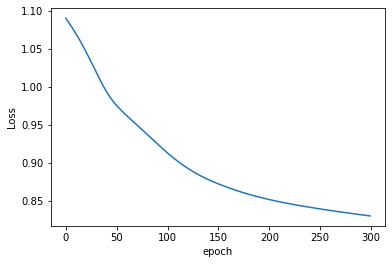

In [38]:
#The loss v epoch graph is polotted, we can see that losses is becoming constant
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [39]:
#Test data score
with torch.no_grad():
    y_val = model(x_test)
    loss = loss_func(y_val, y_test)
print(f'Loss: {loss:.8f}')

Loss: 0.83198464


In [40]:
#argmax is used to obtain the predicted probability
y_val = np.argmax(y_val, axis=1)

In [41]:
# This is basically the same preprossing steps we did with training data.
# Now we are doing for the dataset that is to be predicted with our model.

df_test =  pd.read_csv('Test_set_values.csv')
df_test[['funder','installer']]=df_test[['funder','installer']].applymap(lambda x:x.lower() if isinstance(x, str) else x)

df_num_test = df_test.select_dtypes(include='number', exclude=object)
    
df_obj_test = df_test.select_dtypes(exclude='number')
df_obj_test.replace(value=['nodata/none','nodata/none','nodata/none','nodata/none','zero','zero','zero'], 
                                            to_replace=['NaN','None','none',np.NaN,'0',0,0.0], inplace=True)
df_cleaned_test = pd.concat(objs=[df_obj_test, df_num_test], axis=1)
    
X_real_test = df_cleaned_test
X_real_test['construction_year'].replace(to_replace=0, value=1950, inplace=True)
X_real_test['amount_tsh_percapita'] = list(map(lambda x,y: x/(y+1), 
                                           X_real_test['amount_tsh'], X_real_test['population']))

X_real_test['extraction_type_regrouped'] = X_real_test['extraction_type'].apply(lambda x:x if x not in 
                                 ('windmill','india mark iii',
                                  'other - swn 81','other - play pump','cemo',
                                   'climax', 'walimi', 'other - mkulima/shinyanga') else 'others')
X_real_test['source_regrouped'] = X_real_test['source'].apply(lambda x:x if x not in
                                                      ('other','unknown') else 'others')
X_real_test['waterpoint_type_regrouped'] = X_real_test['waterpoint_type'].apply(lambda x:x if x not in
                                        ('cattle trough', 'dam') else 'cattle trough/dam')
X_real_test['water_quality_regrouped'] = X_real_test['water_quality'].apply(lambda x:x if x not in
                                        ('fluoride','fluoride abandoned') else 'fluoride_group')
X_real_test['management_regrouped'] = X_real_test['management'].apply(lambda x:x if x not in
                                        ('other - school', 'trust') else 'school/trust')

X_real_test = pd.get_dummies(X_real_test, columns=['public_meeting','region','basin','payment_type','extraction_type_regrouped',
                                                  'permit','source_regrouped','quantity','waterpoint_type_regrouped',
                                                 'water_quality_regrouped', 'management_regrouped'], drop_first=True)

X_real_test = X_real_test.drop(labels=['id','region_code','extraction_type_regrouped_other'
                  ,'water_quality_regrouped_salty'], axis=1)
X_real_test = X_real_test.select_dtypes(exclude=object)

scaler = MinMaxScaler()
x_real_test = scaler.fit_transform(X_real_test)

x_real_test = np.array(x_real_test)
x_real_test = torch.tensor(x_real_test).type(torch.FloatTensor)

In [42]:
class_list = list(ctg_dict.items())
class_dict_reverse = {i[1]: i[0] for i in list(class_list)}

#Predicting with neural network
with torch.no_grad():
    y_val = model(x_real_test)
    y_pred_neural = np.argmax(y_val, axis=1)
    y_pred_neural = y_pred_neural.tolist()
    
    
y_pred_neural = list(map(lambda x: class_dict_reverse[x], y_pred_neural))
df_test['status_group'] = y_pred_neural
df_test[['id','status_group']].to_csv('neural_network.csv',index=False)


## Random Forest  - Second Submission

First, separate the columns into dependent and independent variables (or features and labels). 

Then split those variables into a training and test set.

In [43]:
from sklearn.model_selection import train_test_split

def cat_to_group(y_class):
    classes = list(set(y_class))
    classes.sort()
    dict1 = {j:i for i,j in enumerate(classes)}
    y_class_numeric = list(map(lambda x:dict1[x], y_class))
    return y_class_numeric, dict1

y = df_transformed['status_group']
y_trans, ctg_dict = cat_to_group(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=100)

##### Train the Random Forest model on the training set and then perform predictions on the test set.

Having done some research, here is a list of important parameters for random forest. 

1. n_estimators: The number of trees in the forest.

2. min_samples_split: min number of data points placed in a node before the node is split

3. max_depth: n_estimators = number of trees in the foreset

4. max_feature: The number of features to consider when looking for the best split:

cv which is the number of folds to use for cross validation，we use 4 folds 

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

# To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting:
param_grid_Test = {
    'max_depth': [5, 8, 15],
    'max_features': [2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50,100,150]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model 
grid_search = GridSearchCV(rf, param_grid_Test, 
                          cv = 5, n_jobs = -1, verbose = 1)

# Fit it using Scikit-Learn Package 
grid_search.fit(X_train, y_train)
y_RF_pred = grid_search.predict(X_test)
y_RF_pred_train = grid_search.predict(X_train)


# We create confusion matrix to see the accuracy score of this Random Forest Model for both Tranning Set and Test Set 
print('Report for train instances')
print(confusion_matrix(y_train, y_RF_pred_train))
print(classification_report(y_train, y_RF_pred_train))
print('Report for test instances')
print(confusion_matrix(y_test, y_RF_pred))
print(classification_report(y_test, y_RF_pred))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.5min finished


Report for train instances
[[24774    38  1026]
 [ 2375   554   522]
 [ 4896    33 13302]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86     25838
           1       0.89      0.16      0.27      3451
           2       0.90      0.73      0.80     18231

    accuracy                           0.81     47520
   macro avg       0.85      0.62      0.64     47520
weighted avg       0.83      0.81      0.79     47520

Report for test instances
[[5922   26  473]
 [ 600  107  159]
 [1524   19 3050]]
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      6421
           1       0.70      0.12      0.21       866
           2       0.83      0.66      0.74      4593

    accuracy                           0.76     11880
   macro avg       0.76      0.57      0.59     11880
weighted avg       0.77      0.76      0.74     11880



From the above confusion matrix, we observe that the accuracy score on the training set is 0.86 and the test set is 0.76

In [45]:
class_list = list(ctg_dict.items())
class_dict_reverse = {i[1]: i[0] for i in list(class_list)}

y_pred_random_forest = grid_search.predict(X_real_test)     
y_pred_random_forest = list(map(lambda x: class_dict_reverse[x], y_pred_random_forest))
y_pred_random_forest[:5]
df_test['status_group'] = y_pred_random_forest
df_test[['id','status_group']].to_csv('random_forest.csv',index=False)

## - Third Submission - Improve on random forest

In the first version of random forest, we used Grid search for tuning hyperparameters. For every set of parameters a model is trained and evaluated after which the combination with the best results is put forward. In small parameter spaces grid search can turn out to be quite effective, but in case of a large number of parameters we end up watching the screen for quite some time as the number of parameter combinations exponentially grows with the number of parameters.

Hence, we deciced to obtain better hyperparameters by using Bayesian optimisation. 

It in turn takes into account past evaluations when choosing the hyperparameter set to evaluate next. By choosing its parameter combinations in an informed way, it enables itself to focus on those areas of the parameter space that it believes will bring the most promising validation scores. This approach typically requires less iterations to get to the optimal set of hyperparameter values. Most notably because it disregards those areas of the parameter space that it believes won’t bring anything to the table. Thanks to utility function bayesian optimization is much more efficient in tuning parameters of machine learning algorithms than grid or random search techniques. It can effectively balance “exploration” and “exploitation” in finding global optimum.

Firstly, let us install the bayesian-optimization package.

In [46]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [68]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

Over here,  we define function to optimize Random Forest Classifier by inputting in its hyperparameters n_estimators,max_features, max_depth and min_samples_split. Since it is not a binary classification, we cannot use cross validation score and we have to use the mean of accuracy score on given dataset:

In [69]:
#function to optimize

def rf_cv(n_estimators, min_samples_split, max_features, max_depth):
    val = cross_val_score(
        RandomForestClassifier(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=min(max_features, 0.999), # float
            max_depth=int(max_depth),
            random_state=2
        ),
        X, y_trans, scoring = 'accuracy', cv=5
    ).mean()
    return val

Next, we define a list of range numbers of its hyperparameters.

In [70]:
#bounds of parameters
    
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (50,250),
        'min_samples_split': (2,5),
        'max_features': (0.1, 0.5),
        'max_depth': (15,30)}
)

Main parameters of this function:

n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

Overhere, we set init_points=5, n_iter = 5 so that in total we will get 5+5 = 10 iterations. 

In [71]:
rf_bo.maximize(init_points=5, n_iter = 5)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.807    |  20.17    |  0.3583   |  4.408    |  106.4    |
|  2        |  0.8048   |  28.72    |  0.2078   |  4.897    |  174.9    |
|  3        |  0.805    |  29.06    |  0.2855   |  4.883    |  152.6    |
|  4        |  0.8027   |  27.04    |  0.3064   |  2.223    |  177.4    |
|  5        |  0.8062   |  28.01    |  0.3077   |  4.751    |  243.9    |
|  6        |  0.8061   |  19.72    |  0.4793   |  4.598    |  103.6    |
|  7        |  0.8045   |  23.79    |  0.3614   |  2.609    |  107.5    |
|  8        |  0.799    |  17.8     |  0.1193   |  4.585    |  106.8    |
|  9        |  0.8061   |  19.28    |  0.4092   |  2.469    |  197.4    |
|  10       |  0.8049   |  29.32    |  0.4594   |  4.563    |  224.6    |


# From the above chart, we can observe that 1st Iteration has the highest accuracy score of 0.807.

Let's print out the associated hyperparameters as below: 

In [72]:
rf_bo.max

{'target': 0.8069528619528621,
 'params': {'max_depth': 20.16915564607393,
  'max_features': 0.3583174361598199,
  'min_samples_split': 4.407952461282188,
  'n_estimators': 106.41104232718118}}

With regards to the above hyperparameters, let's build an improved Random Forest Classifier and specify all the hyperparameters as below, and fit the Random Forest Classifier with the entire dataset. 

In [73]:
rfc = RandomForestClassifier(n_estimators= 106, min_samples_split=4, max_features=0.3583, max_depth=20.169, n_jobs=-1)
rfc.fit(X, y_trans)

RandomForestClassifier(max_depth=20.169, max_features=0.3583,
                       min_samples_split=4, n_estimators=106, n_jobs=-1)

In [74]:
class_list = list(ctg_dict.items())
class_dict_reverse = {i[1]: i[0] for i in list(class_list)}

y_pred_random_forest = rfc.predict(X_real_test)     
y_pred_random_forest = list(map(lambda x: class_dict_reverse[x], y_pred_random_forest))
y_pred_random_forest[:5]
df_test['status_group'] = y_pred_random_forest
df_test[['id','status_group']].to_csv('random_forest_improved.csv',index=False)


#Since the third submission has the best performance, we shall use the 3rd model for Part 2 - Prescriptive Analysis
#Merge the df_join with df_test and save as 'df_pre.csv' for Part 2 
df_pre = pd.merge(left=df_join, right=df_test,how='outer')
df_pre.to_csv('df_pre.csv',index=False)